In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns


from utils import get_dfs_full_prop

TREATMENT = "hcomp.txx.resp"

export_folder = f"../data/output/diagrams/{TREATMENT}"
os.makedirs(export_folder, exist_ok=True)


dfs_full_prop = get_dfs_full_prop()

dfs = {}
dfs_full = {}


result_df = pd.DataFrame(index=range(105))
stats = pd.DataFrame(index=["min_offer", "min_offer_final"])

TREATMENTS = {"t00", "t10a", "t11a", "t12", "t13", "t20", "t30", "t31"}
TREATMENTS_MAPPING = {
    "t00": "T0",
#     "t10a": "TAI.R",
#     "t10b": "TAI.R",
    "t12": "T2.0",
    "t13": "T2.1",
    #"t20": "TAIAuto.R",
    "t30": "T3.0",
    "t31": "T3.1",
    
}
TREATMENTS = sorted(TREATMENTS_MAPPING.values())

for treatment, new_treatment in TREATMENTS_MAPPING.items():

    # Read and sanitize the data
    df = pd.read_csv(f"../data/{treatment}/export/result__{treatment}_resp.csv")
    df_full = df.copy()
    # drop_cols = ["worker_id", "resp_worker_id", "prop_worker_id", "updated", "status", "job_id", "status", "timestamp", "rowid", "offer_dss", "offer", "offer_final", "completion_code"]
    drop_cols = ["worker_id", "resp_worker_id", "prop_worker_id", "updated", "status", "job_id", "status", "timestamp", "rowid", "offer_dss", "offer", "offer_final", "completion_code", "prop_time_spent"]
    df = df[[col for col in df.columns if col not in drop_cols]]
    if "min_offer_final" not in df_full:
        df_full["min_offer_final"] = df_full["min_offer"]
    
    treatment = new_treatment
    dfs[treatment] = df
    dfs_full[treatment] = df_full
    result_df[treatment+"."+"min_offer"] = df_full["min_offer"]
    result_df[treatment+"."+"min_offer_final"] = df_full["min_offer_final"]
    stats[treatment] = [df_full["min_offer"].mean(), df_full["min_offer_final"].mean()]
    

cols = [col for col in df.columns if col != "min_offer"] + ["min_offer"]


In [2]:
result_df.describe()

,T0.min_offer,T0.min_offer_final,T2.0.min_offer,T2.0.min_offer_final,T2.1.min_offer,T2.1.min_offer_final,T3.0.min_offer,T3.0.min_offer_final,T3.1.min_offer,T3.1.min_offer_final
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,40.333333,40.333333,41.380952,43.809524,38.904762,41.095238,43.904762,45.904762,42.047619,42.428571
std,18.775837,18.775837,20.887695,21.128315,15.222405,16.495643,23.928790,23.704724,19.148901,19.216808
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000
25%,35.000000,35.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,35.000000
50%,45.000000,45.000000,40.000000,40.000000,45.000000,45.000000,50.000000,50.000000,45.000000,45.000000
75%,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
max,100.000000,100.000000,100.000000,100.000000,85.000000,85.000000,100.000000,100.000000,100.000000,100.000000


<AxesSubplot:>

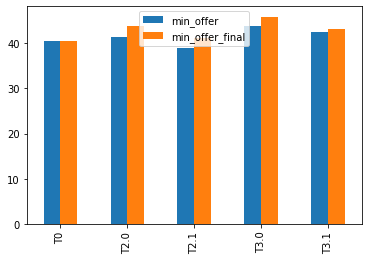

In [3]:
#sns.set()
stats.T.plot.bar()

<AxesSubplot:>

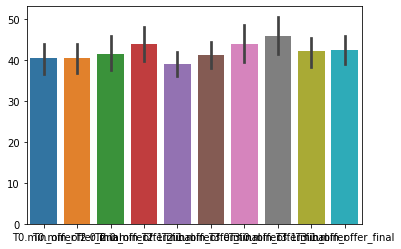

In [4]:
import seaborn as sns

result_df.columns

sns.barplot(data=result_df)

**Correlation to the target value**

**Responder's min_offer / Proposer's over and final_offer distribution**

/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


../data/output/diagrams/hcomp.txx.resp


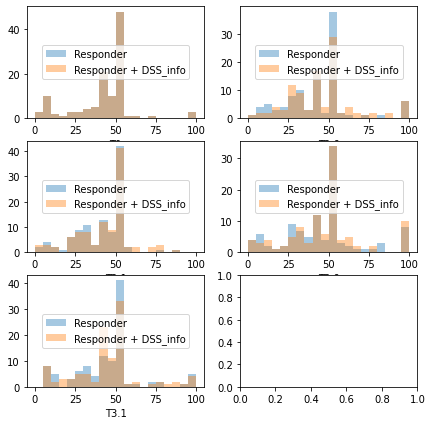

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

In [5]:

bins = list(range(0, 105, 5))

idx = 0

f, axes = plt.subplots(3, 2, figsize=(7, 7))

nb_rows = 3
nb_cols = 2
for treatment in sorted(TREATMENTS):
    df = dfs_full[treatment]
    fig = plt.figure(figsize=(5, 4))
    ax = sns.distplot(df["min_offer"], hist=True, kde=False, bins=bins, ax=axes[idx//nb_cols, idx%nb_cols],  axlabel=treatment, label="Responder")
    _ = ax.legend()
    if treatment.upper() not in {"T0.R"}:
        ax = sns.distplot(df["min_offer_final"], hist=True, kde=False, bins=bins, ax=axes[idx//nb_cols, idx%nb_cols],  axlabel=treatment, label="Responder + DSS_info")
    _ = ax.legend(loc="center")
    
    idx += 1
_ = plt.tight_layout()


f.savefig(os.path.join(export_folder, "min_offers.pdf"), bbox_inches='tight')

print(export_folder)

(21,) (21,)
(21,) (21,)
(21,) (21,)
(21,) (21,)
../data/output/diagrams/hcomp.txx.resp


/usr/local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/site-pack

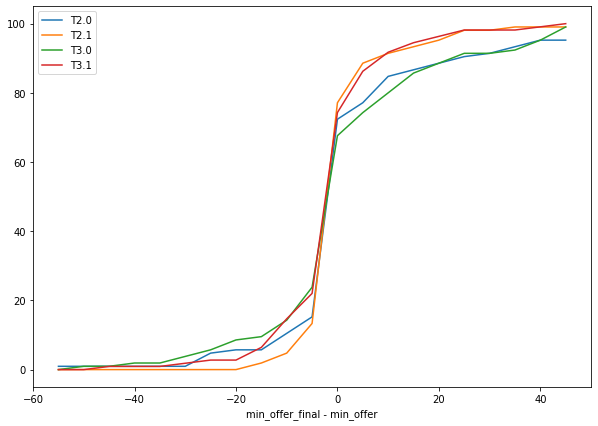

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

In [6]:

bins = np.array(list(range(-55, 55, 5)))
idx = 0

f, axes = plt.subplots(1, 1, figsize=(10, 7))

kwargs = {'cumulative': True}
ax = axes
for treatment in TREATMENTS:
    #ax = axes[idx//3, idx%3]
    df = dfs_full[treatment]
    fig = plt.figure(figsize=(5, 4))
    #ax = sns.distplot(df["offer"], hist=True, kde=False, hist_kws=kwargs, bins=bins, ax=axes[idx//3, idx%3],  axlabel=treatment)
    #_ = ax.legend()
    if treatment.upper() != "T0":
        x = bins[:-1]
        y = np.cumsum(np.histogram(df["min_offer_final"] - df["min_offer"], bins=bins)[0])
        print(x.shape, y.shape)
        y = y * 100 / df.shape[0]
        ax = sns.lineplot(x, y, label=treatment, ax=ax)
        ax.set(xlabel ="min_offer_final - min_offer")
        #ax.legend()
    #_ = ax.legend(loc="center")
    
    idx += 1

plt.tight_layout()
f.savefig(os.path.join(export_folder, "final-min_offer_diff_hist_cumul.pdf"), bbox_inches='tight')

print(export_folder)

../data/output/diagrams/hcomp.txx.resp


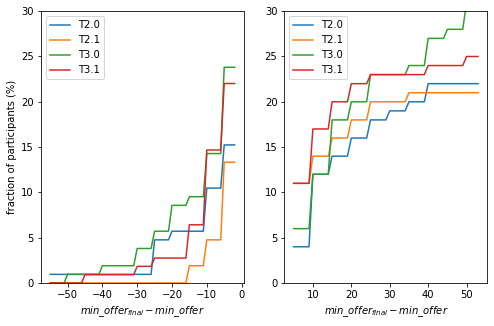

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

In [7]:

bins = np.array(list(range(-55, 55, 5)))
bins_neg = np.array(list(range(-55, 0)))
bins_pos = np.array(list(range(5, 55)))

idx = 0

f, axes = plt.subplots(1, 2, figsize=(8, 5))


kwargs = {'cumulative': True}
ax = axes
for treatment in TREATMENTS:
    #ax = axes[idx//3, idx%3]
    df = dfs_full[treatment]
    fig = plt.figure(figsize=(5, 4))
    #ax = sns.distplot(df["offer"], hist=True, kde=False, hist_kws=kwargs, bins=bins, ax=axes[idx//3, idx%3],  axlabel=treatment)
    #_ = ax.legend()
    if treatment.upper() != "T0":
        x = bins[:-1]
        y_neg = np.cumsum(np.histogram(df["min_offer_final"] - df["min_offer"], bins=bins_neg)[0])
        y_neg = y_neg * 100 / df.shape[0]
        y_pos = np.cumsum(np.histogram(df["min_offer_final"] - df["min_offer"], bins=bins_pos)[0])
        y_pos = y_pos * 100 / df.shape[0]
        #print(x.shape, y.shape)
        ax = axes[0]
        ax = sns.lineplot(x=bins_neg[:-1], y=y_neg, label=treatment, ax=ax)
        ax.set(xlabel ="$min\_offer_{final} - min\_offer$", ylabel="fraction of participants (%)")
        ax.set_ylim(0, 30)
        
        ax = axes[1]
        ax = sns.lineplot(x=bins_pos[:-1], y=y_pos.astype(int), label=treatment, ax=ax)
        ax.set(xlabel ="$min\_offer_{final} - min\_offer$")
        ax.set_ylim(0, 30)
        #ax.legend()
    #_ = ax.legend(loc="center")
    
    idx += 1

plt.tight_layout()
f.savefig(os.path.join(export_folder, "final-min_offer_diff_hist_cumul_split.pdf"), bbox_inches='tight')

print(export_folder)